In [1]:
from qiskit.circuit import QuantumCircuit
from qiskit import transpile, assemble, Aer, IBMQ, execute
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from sympy import Matrix
import matplotlib.pyplot as plt
from qiskit.circuit.instruction import Instruction
from qiskit.circuit.quantumcircuitdata import QuantumCircuitData, CircuitInstruction
from qiskit.circuit.classicalregister import ClassicalRegister, Clbit
from qiskit.circuit.quantumregister import QuantumRegister, Qubit
from qiskit.circuit.library.standard_gates.h import *
import qiskit
import numpy as np

from circuit_remapper import *
from components.layer import *

import warnings

warnings.filterwarnings("ignore")

C:\Users\anura\anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\anura\anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\anura\anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


In [47]:
def measure_sim(qc, samples=20000):
    backend = Aer.get_backend('statevector_simulator')
    circuit = transpile(qc, backend=backend)
    #     print(circuit)
    job = execute(qc, backend, shots=samples)
    counts = job.result().get_counts()
#     print("Job result: ", job.result())
    return counts

##### TEST for TOPOLOGY

In [52]:
# Write a q_map as dictionary
n_q, n_e = 10, 3
qr0 = QuantumRegister(n_q, 'qr0')
qr1 = QuantumRegister(n_e, 'qr1')
q_map = {
    "QPU_1" : [Qubit(qr0, i) for i in range(3)],
    "QPU_2" : [Qubit(qr0, i) for i in range(3,7)],
    "QPU_3" : [Qubit(qr0, i) for i in range(7,n_q)]
}
e_map = {
    "QPU_1" : Qubit(qr1, 0),
    "QPU_2" : Qubit(qr1, 1),
    "QPU_3" : Qubit(qr1, 2)
}
q_map

{'QPU_1': [Qubit(QuantumRegister(10, 'qr0'), 0),
  Qubit(QuantumRegister(10, 'qr0'), 1),
  Qubit(QuantumRegister(10, 'qr0'), 2)],
 'QPU_2': [Qubit(QuantumRegister(10, 'qr0'), 3),
  Qubit(QuantumRegister(10, 'qr0'), 4),
  Qubit(QuantumRegister(10, 'qr0'), 5),
  Qubit(QuantumRegister(10, 'qr0'), 6)],
 'QPU_3': [Qubit(QuantumRegister(10, 'qr0'), 7),
  Qubit(QuantumRegister(10, 'qr0'), 8),
  Qubit(QuantumRegister(10, 'qr0'), 9)]}

###### Test for topology class methods

In [53]:
circuit_topo = Topology(q_map,e_map)

print("Total Number of Qubits in Topology : ", circuit_topo.num_qubits())
print("Total Number of QPUs in Topology: ", circuit_topo.num_hosts())

Qubit1 = q_map["QPU_1"][2]
Qubit2 = q_map["QPU_3"][1]
print("{} and {} are adjacent".format(Qubit1, Qubit2) 
      if circuit_topo.are_adjacent(Qubit1, Qubit2) else 
      "{} and {} are not adjacent".format(Qubit1, Qubit2))

for qubit in circuit_topo.qubits:
    print("Qubit: {} --------- Host: {}".format(qubit, circuit_topo.get_host(qubit)))

Total Number of Qubits in Topology :  10
Total Number of QPUs in Topology:  3
Qubit(QuantumRegister(10, 'qr0'), 2) and Qubit(QuantumRegister(10, 'qr0'), 8) are not adjacent
Qubit: Qubit(QuantumRegister(10, 'qr0'), 0) --------- Host: QPU_1
Qubit: Qubit(QuantumRegister(10, 'qr0'), 1) --------- Host: QPU_1
Qubit: Qubit(QuantumRegister(10, 'qr0'), 2) --------- Host: QPU_1
Qubit: Qubit(QuantumRegister(10, 'qr0'), 3) --------- Host: QPU_2
Qubit: Qubit(QuantumRegister(10, 'qr0'), 4) --------- Host: QPU_2
Qubit: Qubit(QuantumRegister(10, 'qr0'), 5) --------- Host: QPU_2
Qubit: Qubit(QuantumRegister(10, 'qr0'), 6) --------- Host: QPU_2
Qubit: Qubit(QuantumRegister(10, 'qr0'), 7) --------- Host: QPU_3
Qubit: Qubit(QuantumRegister(10, 'qr0'), 8) --------- Host: QPU_3
Qubit: Qubit(QuantumRegister(10, 'qr0'), 9) --------- Host: QPU_3


##### Test for circuit remapper defined in layer.py

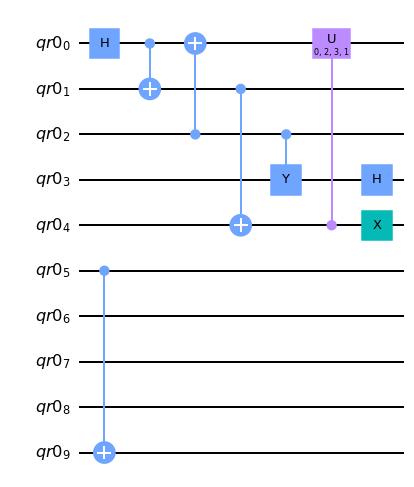

In [63]:
qc = QuantumCircuit(qr0)
qc.h(0)
qc.cx(0,1)
qc.cx(2,0)
qc.cy(2,3)
qc.cx(1,4)
qc.cu(0,2,3,1,4,0)
qc.cx(5,9)
qc.x(4)
qc.h(3)
qc.draw(output='mpl')

In [64]:
circ_object = CircuitRemapper(qc, circuit_topo)
layers_here = circ_object._circuit_to_layers()
layers_here

[[CircuitInstruction(operation=Instruction(name='h', num_qubits=1, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(10, 'qr0'), 0),), clbits=()),
  CircuitInstruction(operation=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(10, 'qr0'), 5), Qubit(QuantumRegister(10, 'qr0'), 9)), clbits=())],
 [CircuitInstruction(operation=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(10, 'qr0'), 0), Qubit(QuantumRegister(10, 'qr0'), 1)), clbits=())],
 [CircuitInstruction(operation=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(10, 'qr0'), 2), Qubit(QuantumRegister(10, 'qr0'), 0)), clbits=()),
  CircuitInstruction(operation=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(10, 'qr0'), 1), Qubit(QuantumRegister(10, 'qr0'), 4)), clbits=())],
 [CircuitInstruction(operation=Instruction(name='cy', num_qubits=2, num_clbits=0

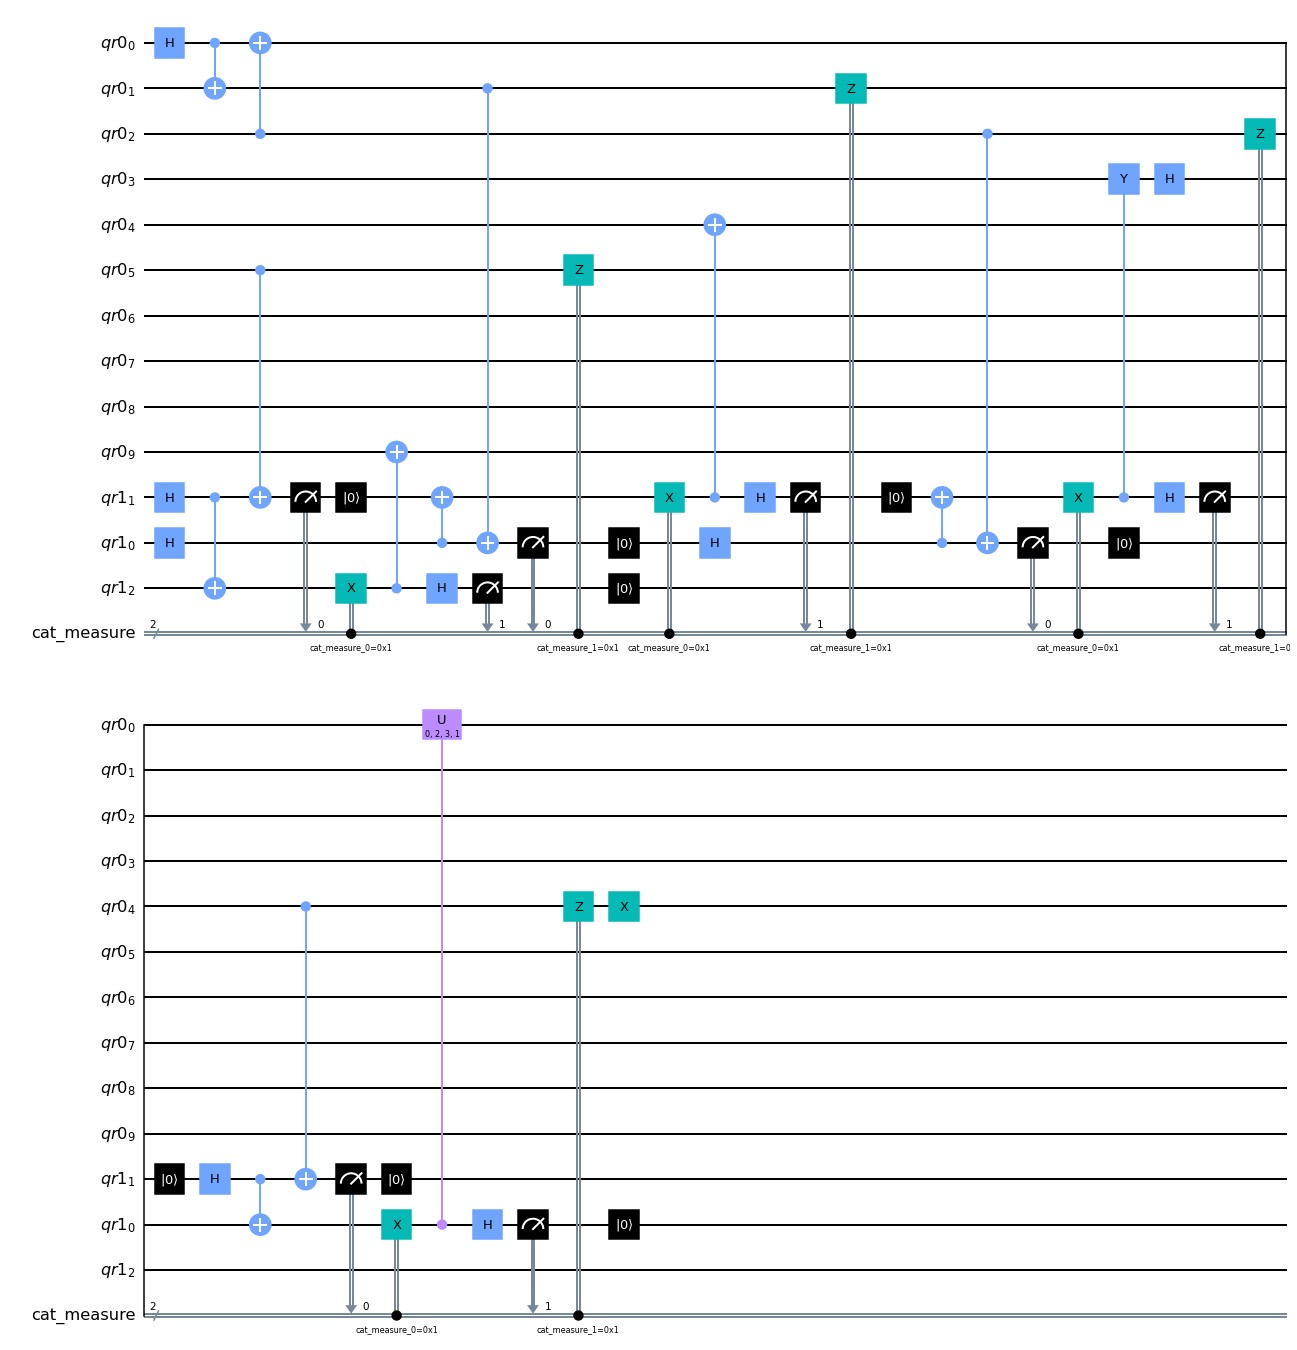

In [65]:
dist_circ = circ_object.remap_circuit()
dist_circ.draw(output='mpl')

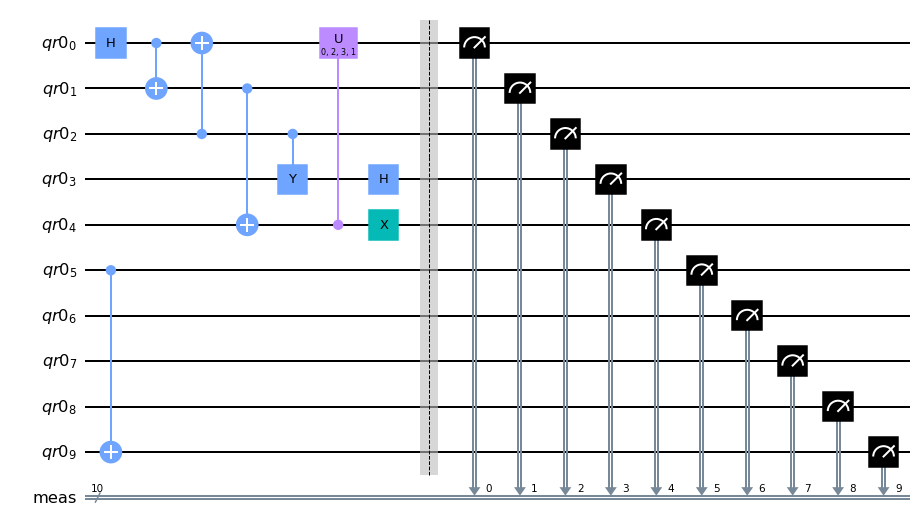

In [66]:
qc.measure_all()
qc.draw('mpl')

{'0000011000': 5052, '0000010000': 4988, '0000000011': 4977, '0000001011': 4983}


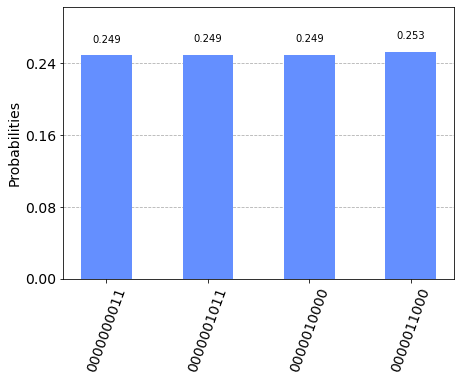

In [67]:
sim_count = measure_sim(qc=qc)
print(sim_count)
plot_histogram(sim_count) 

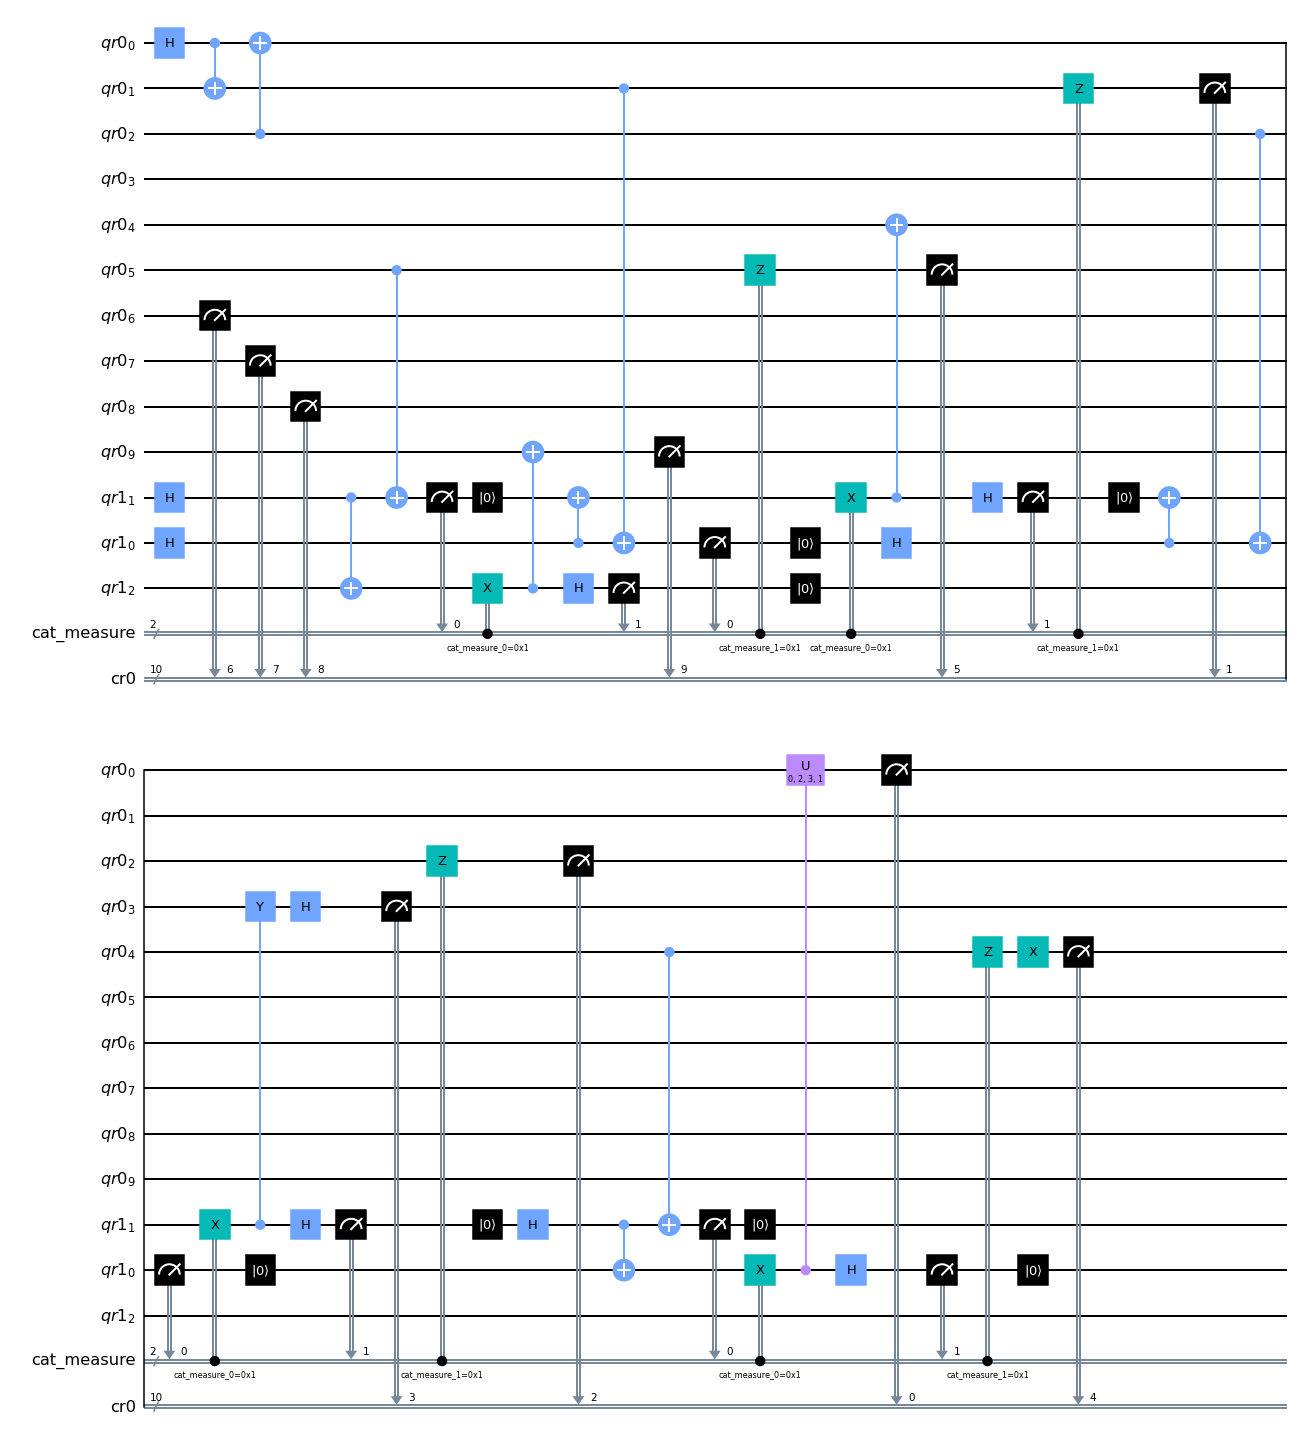

In [68]:
cr0 = ClassicalRegister(n_q, 'cr0')
dist_circ.add_register(cr0)
dist_circ.measure(qr0,cr0)
dist_circ.draw(output='mpl')

{'0000011000': 4944, '0000010000': 5077, '0000001011': 5050, '0000000011': 4929}


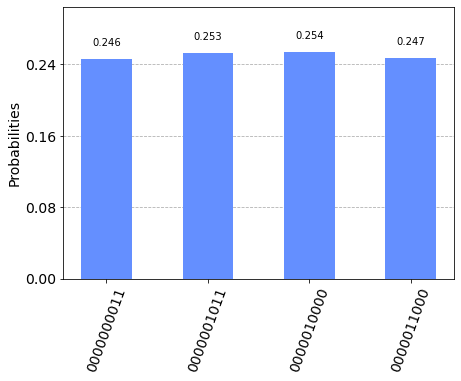

In [69]:
dist_sim_count = measure_sim(qc=dist_circ)
sim_dict = {}
for key in dist_sim_count.keys():
    new_key = key[0:n_q]
    if new_key not in sim_dict.keys():
        sim_dict[new_key] = dist_sim_count[key]
    else:
        sim_dict[new_key] += dist_sim_count[key]
        
print(sim_dict)
plot_histogram(sim_dict) 

In [72]:
## Assert same binary string values in simulation count dictionary to determine equivalence
assert sim_dict.keys() == sim_count.keys()

##### Cat Entangler check

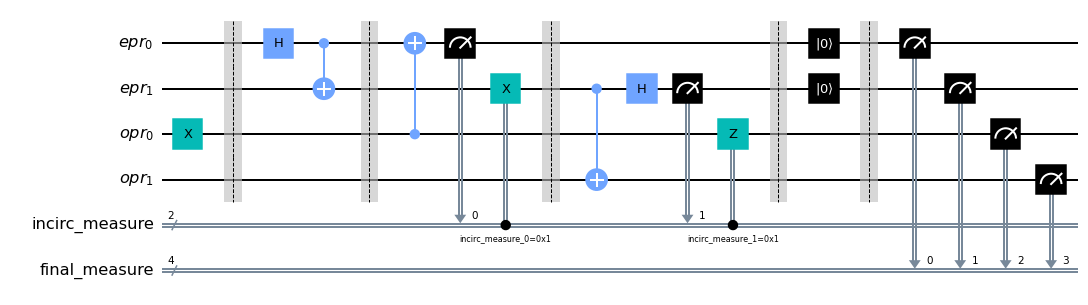

In [20]:
epr_qubits = QuantumRegister(2, "epr")
opr_qubits = QuantumRegister(2, "opr")
measure_bits = ClassicalRegister(2, "incirc_measure")
final_cbits = ClassicalRegister(4, "final_measure")
qc = QuantumCircuit(epr_qubits, opr_qubits, measure_bits, final_cbits)

#check for opr_1 = 1 and opr_2 = 1
qc.x(2)
# qc.x(3)
qc.barrier()

# Generate EPR pair
qc.h(0)
qc.cx(0, 1)
qc.barrier()
# cat entanglement
qc.cx(2,0)
qc.measure(0,0)
qc.x(1).c_if(measure_bits[0], 1)
qc.barrier()
qc.cx(1,3)
qc.h(1)
qc.measure(1,1)
qc.z(2).c_if(measure_bits[1], 1)
qc.barrier()
qc.reset(epr_qubits)

## Measurements
qc.barrier()
qc.measure(epr_qubits, final_cbits[0:2])
qc.measure(opr_qubits, final_cbits[2:4])

qc.draw(output='mpl')

{'1100 00': 2060, '1100 11': 2047, '1100 10': 2117, '1100 01': 1968}


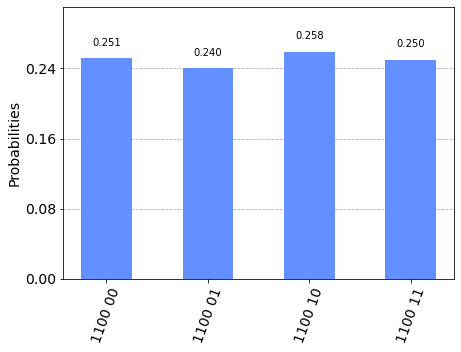

In [21]:
# run circuits on qasm simulator
sim_count = measure_sim(qc=qc)
print(sim_count)
plot_histogram(sim_count)  # Display the output on measurement of state vector

The cat entangling scheme works